# 51. REINFORCE


In [10]:
import gym
import numpy as np
import random
import time
import csv
import matplotlib.pyplot as plt
from itertools import product

env = gym.make('CartPole-v0')

** Feature vector implementation: **

In [121]:
def x(state, action = False):
    # Fourier Basis order-1

    if action is False:
        c_array = product([0,1], repeat = 4)
        features = np.array([np.cos(c@np.array(state)) for c in c_array])
    else:
        c_array = product([0,1], repeat = 5)
        features = np.array([np.cos(np.dot(c,np.concatenate((state, [action])))) for c in c_array])

    # Polynomial Basis order-1

    # c_array = product([0,1], repeat = 5)
    # features = np.array([np.prod(np.concatenate((state, [action + 1]))**np.array(c)) for c in c_array])
    return features

print(x([1,2,3,4]))

[ 1.         -0.65364362 -0.9899925   0.75390225 -0.41614684  0.96017029
  0.28366219 -0.91113026  0.54030231  0.28366219 -0.65364362 -0.14550003
 -0.9899925   0.75390225  0.96017029 -0.83907153]


** Policy implementation: **


In [12]:
def pi(state, theta, env):
    p_array = np.array([np.exp(np.dot(theta, x(state,action))) for action in range(env.action_space.n)])
    return p_array/np.sum(p_array)

def choose_action(state, actions, theta, env):
    weights = pi(state, theta, env)
    return random.choices(population = actions, weights = weights)[0]

In [13]:
def REINFORCE(alpha, gamma, max_episodes, env):
    dim = len(x(env.reset(), env.action_space.sample()))
    theta = np.zeros(dim)
    actions = [i for i in range(env.action_space.n)]
    episode_length_array = np.zeros(max_episodes)
    episode_length_array.fill(10)

    for i in range(max_episodes):
        done = False
        observation = env.reset()
        S = [observation]
        A = []
        R = [0]

        
        T = 0
        while not done:
            action = choose_action(observation, actions, theta, env)
            observation, reward, done, info = env.step(action)
            
            S.append(observation)
            A.append(action)
            R.append(reward)

            T += 1
            if done:
                episode_length_array[i] = T
                # if i%20 == 0:
                #     print(f"Episode {i} finished after {T} timesteps")
                    
                #     if T < 100:
                #         mean = np.mean(episode_length_array[:T])
                #     else:
                #         mean = np.mean(episode_length_array[T-100:T])
                #     print("Average length (last 100): ", mean)
                break
        for t in range(T):
            G = sum([gamma**(k-t-1)*R[k] for k in range(t+1,T+1)])
            probabilities = pi(S[t], theta, env)
            features = np.array([x(S[t],action) for action in actions])
            gradient = x(S[t],A[t]) - probabilities @ features
            theta += alpha*gamma**t*(G-10)*gradient
        
    
    return theta, episode_length_array

In [65]:
alpha_array = [0.01, 0.05, 0.1]
gamma = 1
max_episodes = 500

for alpha in alpha_array:
    for i in range(10):
        theta, episode_length_array = REINFORCE(alpha, gamma, max_episodes, env)

        fieldnames = ["alpha", "episode_lengths"]
        with open("results_500.csv", "a") as file:
            writer = csv.writer(file)

            writer.writerow([alpha, episode_length_array])
        print(alpha, i)
    

0.01 0
0.01 1
0.01 2
0.01 3
0.01 4
0.01 5
0.01 6
0.01 7
0.01 8
0.01 9


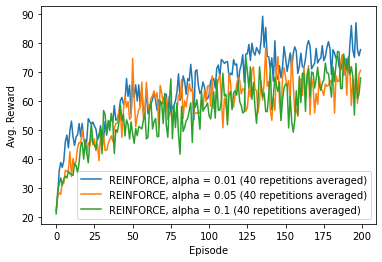

In [67]:
alpha_array = [0.01, 0.05, 0.1]

with open("results_200.csv", "r") as file:
    reader = csv.reader(file)
    avg_length = {alpha: np.zeros(200) for alpha in alpha_array}
    counter = {alpha: 0 for alpha in alpha_array}
    for row in reader:
        if row != []:
            alpha = float(row[0])
            counter[alpha] += 1
            episode_length_array = np.array(row[1].strip("[]").split()).astype(np.float)
            avg_length[alpha] = avg_length[alpha] + 1/counter[alpha]*(episode_length_array - avg_length[alpha])
    

for alpha in alpha_array:
    plt.plot(avg_length[alpha], label = f"REINFORCE, alpha = {alpha} ({counter[alpha]} repetitions averaged)")
    plt.xlabel("Episode")
    plt.ylabel("Avg. Reward")
    plt.legend()

plt.show()

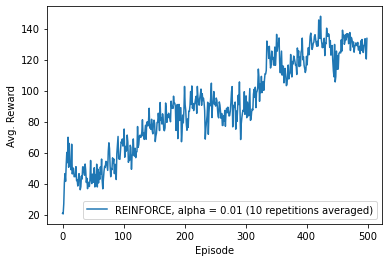

In [68]:
alpha = 0.01

with open("results_500.csv", "r") as file:
    reader = csv.reader(file)
    avg_length = np.zeros(500)
    counter = 0
    for row in reader:
        if row != []:
            counter += 1
            episode_length_array = np.array(row[1].strip("[]").split()).astype(np.float)
            avg_length = avg_length + 1/counter*(episode_length_array - avg_length)
    

plt.plot(avg_length, label = f"REINFORCE, alpha = {alpha} ({counter} repetitions averaged)")
plt.xlabel("Episode")
plt.ylabel("Avg. Reward")
plt.legend()

plt.show()

** REINFORCE with variable alpha **

In [91]:
def REINFORCE(alpha, gamma, max_episodes, env):
    dim = len(x(env.reset(), env.action_space.sample()))
    theta = np.zeros(dim)
    actions = [i for i in range(env.action_space.n)]
    episode_length_array = np.zeros(max_episodes)
    episode_length_array.fill(10)

    for i in range(max_episodes):
        done = False
        observation = env.reset()
        S = [observation]
        A = []
        R = [0]

        
        T = 0
        while not done:
            action = choose_action(observation, actions, theta, env)
            observation, reward, done, info = env.step(action)
            
            S.append(observation)
            A.append(action)
            R.append(reward)

            T += 1
            if done:
                episode_length_array[i] = T
                # if i%20 == 0:
                #     print(f"Episode {i} finished after {T} timesteps")
                    
                #     if T < 100:
                #         mean = np.mean(episode_length_array[:T])
                #     else:
                #         mean = np.mean(episode_length_array[T-100:T])
                #     print("Average length (last 100): ", mean)
                break
        for t in range(T):
            G = sum([gamma**(k-t-1)*R[k] for k in range(t+1,T+1)])
            probabilities = pi(S[t], theta, env)
            features = np.array([x(S[t],action) for action in actions])
            gradient = x(S[t],A[t]) - probabilities @ features
            theta += alpha(i+1)*gamma**t*(G-10)*gradient
        
    
    return theta, episode_length_array

In [148]:
def alpha(i):
    return 1/i

gamma = 1
max_episodes = 200

for i in range(10):
    theta, episode_length_array = REINFORCE(alpha, gamma, max_episodes, env)
    with open("results_200_variable_alpha.csv", "a") as file:
        writer = csv.writer(file)

        writer.writerow(episode_length_array)
    print(i)

0
1
2
3
4
5
6
7
8
9


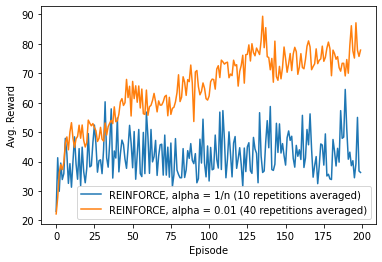

In [147]:

with open("results_200_variable_alpha.csv", "r") as file:
    reader = csv.reader(file)
    avg_length = np.zeros(200)
    counter = 0
    for row in reader:
        if row != []:
            counter += 1
            episode_length_array = np.array(row).astype(np.float)
            avg_length = avg_length + 1/counter*(episode_length_array - avg_length)
    

plt.plot(avg_length, label = f"REINFORCE, alpha = 1/n ({counter} repetitions averaged)")
plt.xlabel("Episode")
plt.ylabel("Avg. Reward")
plt.legend()

alpha_array = [0.01, 0.05, 0.1]

with open("results_200.csv", "r") as file:
    reader = csv.reader(file)
    avg_length = {alpha: np.zeros(200) for alpha in alpha_array}
    counter = {alpha: 0 for alpha in alpha_array}
    for row in reader:
        if row != []:
            alpha = float(row[0])
            counter[alpha] += 1
            episode_length_array = np.array(row[1].strip("[]").split()).astype(np.float)
            avg_length[alpha] = avg_length[alpha] + 1/counter[alpha]*(episode_length_array - avg_length[alpha])
    


plt.plot(avg_length[0.01], label = f"REINFORCE, alpha = {0.01} ({counter[0.01]} repetitions averaged)")
    
plt.xlabel("Episode")
plt.ylabel("Avg. Reward")   
plt.legend()
plt.show()

** Reinforce with Baseline **

In [127]:
def v(state, w):
    return x(state)@w

def nabla_v(state,w):
    return x(state)

In [128]:
def REINFORCE_BASELINE(alpha_w, alpha_theta, gamma, max_episodes, env):
    dim = len(x(env.reset(), env.action_space.sample()))
    theta = np.zeros(dim)
    w = np.zeros(len(x(env.reset())))

    actions = [i for i in range(env.action_space.n)]
    episode_length_array = np.zeros(max_episodes)
    episode_length_array.fill(10)

    for i in range(max_episodes):
        done = False
        observation = env.reset()
        S = [observation]
        A = []
        R = [0]

        
        T = 0
        while not done:
            
            action = choose_action(observation, actions, theta, env)
            observation, reward, done, info = env.step(action)
            
            S.append(observation)
            A.append(action)
            R.append(reward)

            T += 1
            if done:
                episode_length_array[i] = T
                if i%20 == 0:
                break
        for t in range(T):
            G = sum([gamma**(k-t-1)*R[k] for k in range(t+1,T+1)])
            delta = G - v(S[t],w)
            probabilities = pi(S[t], theta, env)
            features = np.array([x(S[t],action) for action in actions])
            gradient = x(S[t],A[t]) - probabilities @ features

            w += alpha_w*delta*nabla_v(S[t], w)
            theta += alpha_theta*gamma**t*delta*gradient
        
    
    return theta, episode_length_array

In [133]:
alpha_theta_array = [0.01, 0.05, 0.1]
alpha_w = 0.1
gamma = 1
max_episodes = 200

for alpha_theta in alpha_theta_array:
    for i in range(9):
        theta, episode_length_array = REINFORCE_BASELINE(alpha_w, alpha_theta, gamma, max_episodes, env)

        with open("results_200_baseline.csv", "a") as file:
            writer = csv.writer(file)

            writer.writerow([alpha_theta, episode_length_array])
        print(alpha_theta, i)

ps
Average length (last 100):  10.583333333333334
Episode 20 finished after 17 timesteps
Average length (last 100):  16.0
Episode 40 finished after 10 timesteps
Average length (last 100):  15.4
Episode 60 finished after 11 timesteps
Average length (last 100):  15.181818181818182
Episode 80 finished after 17 timesteps
Average length (last 100):  16.0
Episode 100 finished after 15 timesteps
Average length (last 100):  15.133333333333333
Episode 120 finished after 17 timesteps
Average length (last 100):  16.0
Episode 140 finished after 11 timesteps
Average length (last 100):  15.181818181818182
Episode 160 finished after 18 timesteps
Average length (last 100):  16.11111111111111
Episode 180 finished after 9 timesteps
Average length (last 100):  15.333333333333334
0.01 2
Episode 0 finished after 28 timesteps
Average length (last 100):  10.642857142857142
Episode 20 finished after 28 timesteps
Average length (last 100):  16.5
Episode 40 finished after 20 timesteps
Average length (last 100):

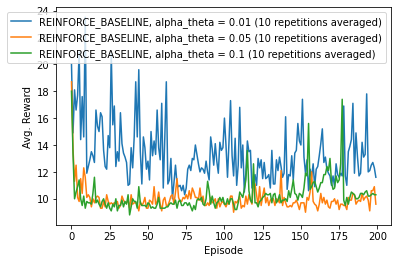

In [135]:
alpha_theta_array = [0.01, 0.05, 0.1]

with open("results_200_baseline.csv", "r") as file:
    reader = csv.reader(file)
    avg_length = {alpha: np.zeros(200) for alpha in alpha_theta_array}
    counter = {alpha: 0 for alpha in alpha_array}
    for row in reader:
        if row != []:
            alpha = float(row[0])
            counter[alpha] += 1
            episode_length_array = np.array(row[1].strip("[]").split()).astype(np.float)
            avg_length[alpha] = avg_length[alpha] + 1/counter[alpha]*(episode_length_array - avg_length[alpha])
    

for alpha_theta in alpha_theta_array:
    plt.plot(avg_length[alpha_theta], label = f"REINFORCE_BASELINE, alpha_theta = {alpha_theta} ({counter[alpha]} repetitions averaged)")
    plt.xlabel("Episode")
    plt.ylabel("Avg. Reward")
    plt.legend()

plt.show()

** One-step actor-critic method **

In [141]:
def actor_critic(alpha_w, alpha_theta, gamma, max_episodes, env):
    dim = len(x(env.reset(), env.action_space.sample()))
    theta = np.zeros(dim)
    w = np.zeros(len(x(env.reset())))

    actions = [i for i in range(env.action_space.n)]
    episode_length_array = np.zeros(max_episodes)
    episode_length_array.fill(10)

    for i in range(max_episodes):
        done = False
        observation = env.reset()
        S = [observation]
        A = []
        R = [0]
        I = 1

        
        T = 0
        while not done:
            action = choose_action(observation, actions, theta, env)
            new_observation, reward, done, info = env.step(action)

            if not done:
                delta = reward + gamma*v(new_observation,w) - v(observation, w)
            else:
                delta = reward - v(observation, w)

            w += alpha_w*delta*nabla_v(observation,w)

            probabilities = pi(observation, theta, env)
            features = np.array([x(observation,action) for action in actions])
            gradient = x(observation,action) - probabilities @ features
            theta += alpha_theta*I*delta*gradient

            I = gamma*I
            
            observation = new_observation

            T += 1
            if done:
                episode_length_array[i] = T
                break    
    
    return theta, episode_length_array

In [149]:
alpha_theta_array = [0.01, 0.05, 0.1]
alpha_w = 0.1
gamma = 1
max_episodes = 200

for alpha_theta in alpha_theta_array:
    for i in range(10):
        theta, episode_length_array = actor_critic(alpha_w, alpha_theta, gamma, max_episodes, env)

        with open("results_200_actorcritic.csv", "a") as file:
            writer = csv.writer(file)

            writer.writerow([alpha_theta, episode_length_array])
        print(alpha_theta, i)

0.01 0
0.01 1
0.01 2
0.01 3
0.01 4
0.01 5
0.01 6
0.01 7
0.01 8
0.01 9
0.05 0
0.05 1
0.05 2
0.05 3
0.05 4
0.05 5
0.05 6
0.05 7
0.05 8
0.05 9
0.1 0
0.1 1
0.1 2
0.1 3
0.1 4
0.1 5
0.1 6
0.1 7
0.1 8
0.1 9


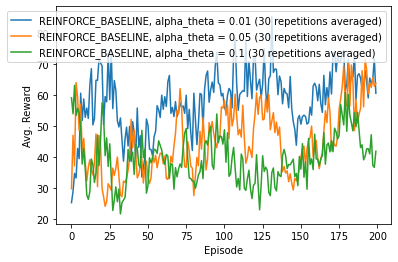

In [150]:
alpha_theta_array = [0.01, 0.05, 0.1]

with open("results_200_actorcritic.csv", "r") as file:
    reader = csv.reader(file)
    avg_length = {alpha: np.zeros(200) for alpha in alpha_theta_array}
    counter = {alpha: 0 for alpha in alpha_array}
    for row in reader:
        if row != []:
            alpha = float(row[0])
            counter[alpha] += 1
            episode_length_array = np.array(row[1].strip("[]").split()).astype(np.float)
            avg_length[alpha] = avg_length[alpha] + 1/counter[alpha]*(episode_length_array - avg_length[alpha])
    

for alpha_theta in alpha_theta_array:
    plt.plot(avg_length[alpha_theta], label = f"REINFORCE_BASELINE, alpha_theta = {alpha_theta} ({counter[alpha]} repetitions averaged)")
    plt.xlabel("Episode")
    plt.ylabel("Avg. Reward")
    plt.legend()

plt.show()

In [7]:
env.close()